In [2]:
import pandas as pd
import io
import requests

customers_file_id = '1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE'
products_file_id = '1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0'
transactions_file_id = '1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF'

def read_csv_from_google_drive(file_id):
    """Reads a CSV file from Google Drive given its file ID."""
    url = f'https://docs.google.com/uc?export=download&id={file_id}'
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(io.StringIO(response.text))

customers = read_csv_from_google_drive(customers_file_id)
products = read_csv_from_google_drive(products_file_id)
transactions = read_csv_from_google_drive(transactions_file_id)

In [3]:
encoder = OneHotEncoder(sparse_output=False)
region_encoded = encoder.fit_transform(customers[['Region']])
region_df = pd.DataFrame(region_encoded, columns=encoder.categories_[0], index=customers['CustomerID'])

In [4]:
transactions_with_customers = pd.merge(transactions, customers, on="CustomerID", how="left")
transactions_with_customers = pd.merge(transactions_with_customers, products, on="ProductID", how="left", suffixes=('_trans', '_prod'))

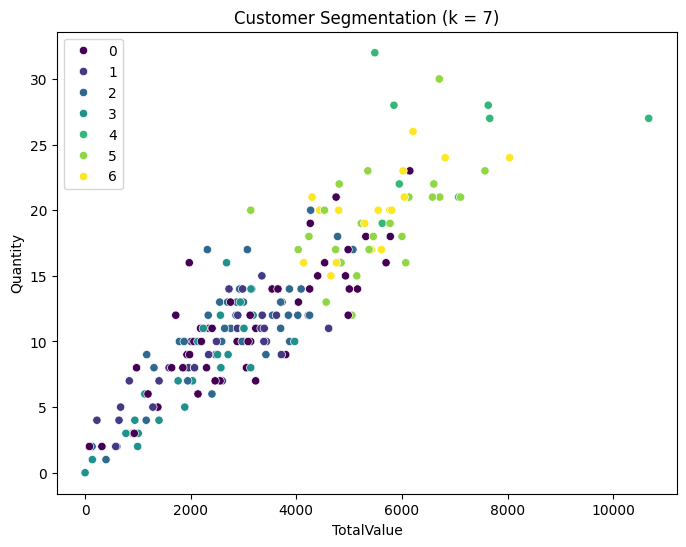

Optimal Number of Clusters: 7
Davies-Bouldin Index: 0.67
Silhouette Score: 0.58


In [6]:
customer_transactions = transactions_with_customers.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left').fillna(0)
customer_data = pd.merge(customer_data, region_df, on='CustomerID', how='left')

features = ['TotalValue', 'Quantity'] + list(region_df.columns)
X = customer_data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


best_score = -1
best_k = -1
db_index = -1
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
  kmeans.fit(X_scaled)
  labels = kmeans.labels_
  score = silhouette_score(X_scaled, labels)
  db = davies_bouldin_score(X_scaled, labels)
  if score > best_score:
      best_score = score
      best_k = k
      db_index = db

kmeans = KMeans(n_clusters=best_k, random_state=0, n_init = 10)
kmeans.fit(X_scaled)
labels = kmeans.labels_
db_index = davies_bouldin_score(X_scaled, labels)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['TotalValue'], y=X['Quantity'], hue=labels, palette='viridis')
plt.title(f'Customer Segmentation (k = {best_k})')
plt.show()

print(f"Optimal Number of Clusters: {best_k}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {best_score:.2f}")

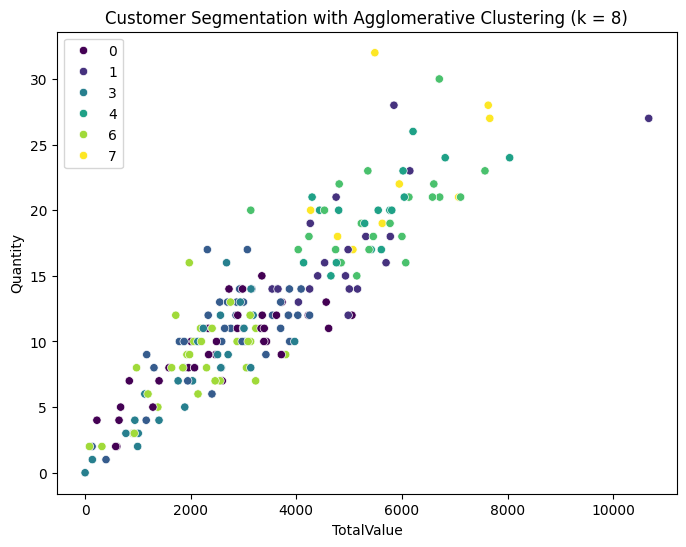

Optimal Number of Clusters (Agglomerative): 8
Davies-Bouldin Index (Agglomerative): 0.59
Silhouette Score (Agglomerative): 0.57


In [8]:

from sklearn.cluster import AgglomerativeClustering

best_score_agg = -1
best_k_agg = -1
db_index_agg = -1
for k in range(2, 11):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    agg_clustering.fit(X_scaled)
    labels_agg = agg_clustering.labels_
    score_agg = silhouette_score(X_scaled, labels_agg)
    db_agg = davies_bouldin_score(X_scaled, labels_agg)
    if score_agg > best_score_agg:
        best_score_agg = score_agg
        best_k_agg = k
        db_index_agg = db_agg

agg_clustering = AgglomerativeClustering(n_clusters=best_k_agg)
agg_clustering.fit(X_scaled)
labels_agg = agg_clustering.labels_


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['TotalValue'], y=X['Quantity'], hue=labels_agg, palette='viridis')
plt.title(f'Customer Segmentation with Agglomerative Clustering (k = {best_k_agg})')
plt.show()

print(f"Optimal Number of Clusters (Agglomerative): {best_k_agg}")
print(f"Davies-Bouldin Index (Agglomerative): {db_index_agg:.2f}")
print(f"Silhouette Score (Agglomerative): {best_score_agg:.2f}")